# Towards Scientific Programming

Today we'll look at what it takes to handle truly **huge** amounts of data, as one often would when dealing with scientific data.

As we've seen, with most algorithms & data structures the limiting factor will be the amount of data.

Everything is "easy" when the data is small.

### Example O(1) Operations

- add/remove on linked list
- modify array at the end
- array access

### Example O(n) Operations

- A linear search for a record in sequence.
- Always *some* operations on a linked list/array type, depending on which is chosen.
    - insert at start/middle of array
    - access random element in linked list
- Memory-move type operations (list/hashtable outgrows allocated memory)
- String concatenation with `__add__`

### Example O(log2 n) Operations

- Binary search/sort.
- Grow slower, but overhead & memory complexity can still limit large data sets.

### Example O(n^2) / O(n*m) Operations

- Comparing every item to every other item. (Simple checking for duplicates.)
- Generally: Nested O(n) operations.  (for each of N files, for each of M words in file...)

**And remember, to get better performance we are often spending extra memory**.  

So what happens when data gets too big?

## Strategies for "big" data.

I am avoiding the term of art "Big Data" which often has specific connotations.  Our "big data" would encompass "Big Data" but also any data where performance starts to become an issue.

### "Premature Optimization is the Root of All Evil"

(-Donald Knuth)

A halllmark of an "intermediate" programmer is that they have all of the tools of the experienced programmer, but they lack the wisdom to know when to use which one. 

A common mistake stems from attempts to optimize code that was never going to be the bottleneck.

Generally, when there is a straighforward way to do something, do it first!

Write your code in an organized way and you'll be able to fairly easily adapt if it turns out that you need to optimize it with one of the techniques introduced below.

For example, if you need to do something 1,000,000 times.

Start with a function that performs that task. And call it on a subset of that data:

```
for item in full_data_set[:10000]:
    do_something(item)
```

If this takes 1 minute to run, then your full data set will take 100 minutes.  

- Will it save you more than that to rewrite?
- What if it needs to run every week?
- What if it takes 1 hour?

Let's say it is still too slow: what then?

### Strategy 1: Better Algorithms & Data Structures

Before employing the strategies below, it is generally advisable to think about what portions of your code are slow.

Sometimes, for a simple enough program, or an experienced enough dev, you can reason this out, but if in doubt you should **profile** your code to determine the slowest portions and work to optimize them.  The results can be surprising, perhaps you are calling a method that does a `deepcopy` that you didn't realize was there, or using an array where a linked list would be more appropriate.

- `timeit`
- `cProfile`

<https://docs.python.org/3/library/profile.html>

### Python's General Performance

Python's flexibility comes with costs. Python has a reputation for slowness in some contexts. Other implementations of the Python interpreter attempt to overcome some of the default implementation's shortcomings (e.g., Cython, PyPy, Numba).

> The relative sluggishness of Python generally manifests itself in situations where many small operations are being repeated—for instance, looping over arrays to operate on each element.
> It turns out that the bottleneck [...] is not the operations themselves, but the type-checking and function dispatches that CPython must to at each cycle of the loop." [This is where compiled code has an advantage.]

**-Jake VanderPlas, Python Data Science Handbook**

Solution: *vectorized* functions via "ufuncs" that circumvent problems of this nature.

These functions execute in the C-layer instead of the Python layer. They bypass type checking, dunder lookups, and other overhead, allowing the full speed of the CPU (and GPU) to be utilized.

Data will still be the limiting factor, but if we can get a 10-100x speedup, that's another order of magnitude or two worth of data we can process per machine. (So when combined with parallelization, can drastically save on costs.)

### Strategy 2: Parallelization

Depending on the needs of the program, your next bet may be to paralellize the operations.

This means splitting the data up into smaller pieces, and have multiple processing pipelines handle subsets of the data.

This can mean multiple computers on a network, or on modern machines, multiple threads or processes on the same machine.

A full exploration of this is beyond the scope of what we can cover in this class, but here are some techniques:

- [`threading`](https://docs.python.org/3/library/threading.html)
- [`subprocess`](https://docs.python.org/3/library/subprocess.html)
- [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html)
- `async/await` - <https://docs.python.org/3/library/asyncio-task.html>

### Aside: the GIL

Python has a feature known as the "global interpreter lock" which prevents two Python threads from modifying the same data structure at the same time.

This means that two threads can't accidentally remove the same item from a list, or set the same key in a dictionary to two different values.  It comes at the expense of performance, since you lose the ability to use these data structures concurrently whatsover.

Some languages give much more finely grained control, which comes with more responsibility & room for error.

For this reason, most Python programs prefer subprocesses to subthreads.  (If you take parallel programming or an operating systems course you will likely explore the differences.)

Python 3.13 supports an experimental GIL-free mode, something that's been considered unlikely for 20+ years. This could be the biggest change to the language in decades.

### Strategy 3: Vectorization

Another approach that can help in tandem with parallelization, and which can be easier to reach for without refactoring your code, is to take advantage of modern hardware's support for vectorization.

Vectorization takes advantage of the fact that it is often cheap to do the same operation to adjacent memory locations.

With a large array, instead of adding +1 to each item, the array could instead be merged with [+1, +1, +1, +1, +1, +1, +1, +1...] incrementing many items simultaneously.

## Arrays

Python's dynamic typing makes it extremely flexible, but this flexibility comes at a cost.

Python's built in types are often cleverly disguised C structures containing the data associated with the object as well as header information.

Every Python `object` has a header:

- `ob_refcnt`: reference count used for garbage collection
- `ob_type`: type of the object (how to interpret underlying bytes)
- `obj_size`: size of data in bytes

Lists (for example) are extremely flexible and can hold any `object`, we've said these things are in adjacent memory, but how does that work if the items are a different size?

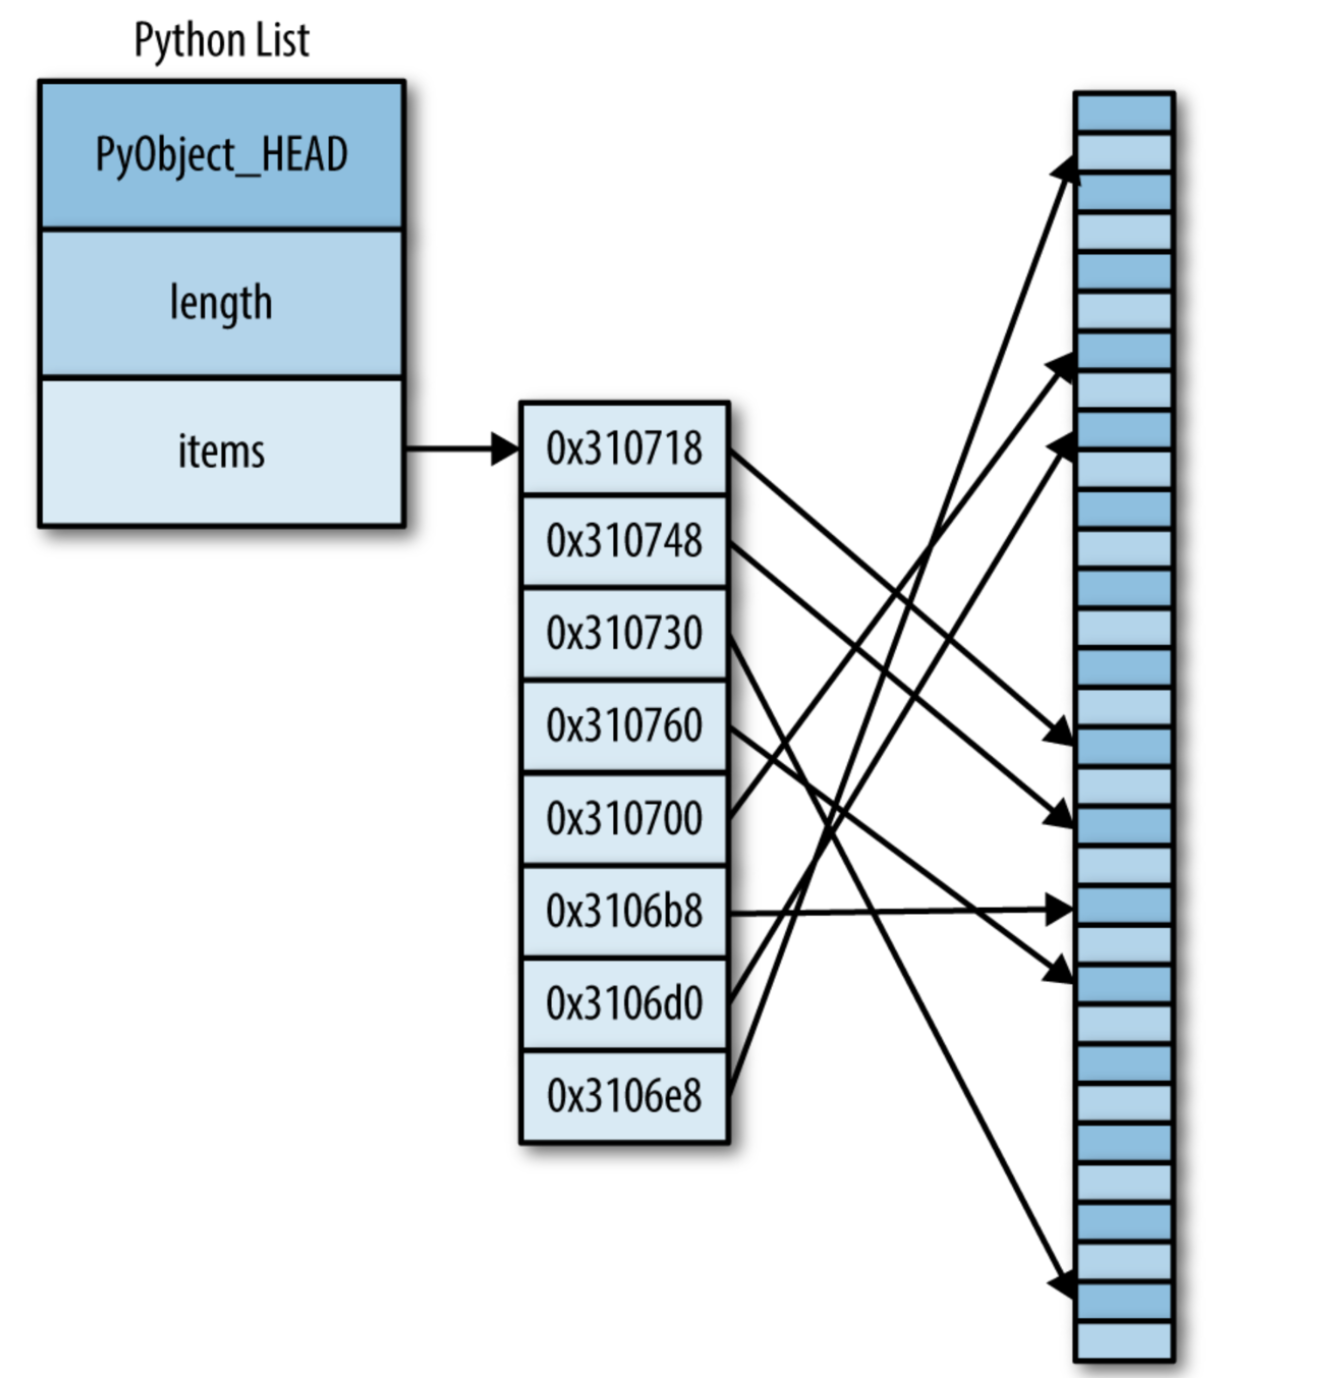

Lookups are still O(1), but there is an extra level of indirection, as we've discussed.

### `array` module

Allows us to create dense, **homogenous** arrays without indirection. 

Unlike `list` (and virtually everything else) we actually need to declare a type when doing so.


In [1]:
import array

# array of 10 integers
int_ar = array.array("i", range(10))
float_ar = array.array("f", range(10))
print(int_ar)
print(float_ar)

array('i', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
array('f', [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])


## NumPy Arrays

Python's `array` object provides efficient storage on array-based data, **NumPy** adds efficient operations on that data as well as a nicer interface.

NumPy will upcast data if there is data of different types in a single array.  For example:

In [2]:
import numpy as np
print(np.array([1, 2, 3, 4, 5]))  
print(np.array([1, 2, 3, 4., 5]))  # one float will make the entire array floats

[1 2 3 4 5]
[1. 2. 3. 4. 5.]


In [3]:
# you can also specify the type via `dtype`
print(np.array([1, 2, 3, 4, 5], dtype="float32"))  
# all types: https://numpy.org/doc/stable/user/basics.types.html

[1. 2. 3. 4. 5.]


NumPy arrays are multidimensional.  The arrays we've seen are just a special case with one axis.

- **axes**: In NumPy dimensions are usually called axes.
- **rank**: Number of axes in a given array.
- **length**: number of elements in a given axis.
- **shape**: size of array in each axis, given as a tuple.
- **size**: total number of elements in entire array (all axes).
- **itemsize**: Size in bytes of each element in array.
- **data**: Underlying buffer used to store data, generally not accessed directly.

In [4]:
a = np.array([[1, 2, 3], [4, 5, 6]], dtype="float32")
print(a[0, 1])  # Note: multidimensional access, different from m[0][1]

2.0


In [5]:
a[:, 0]  # entire row

array([1., 4.], dtype=float32)

In [6]:
a[:, 0] # entire column

array([1., 4.], dtype=float32)

In [7]:
print('rank =', len(a.shape))
print('shape =', a.shape)
print('size =', a.size)
print('itemsize =', a.itemsize)
print('data =', a.data)

rank = 2
shape = (2, 3)
size = 6
itemsize = 4
data = <memory at 0x108169080>


### Creating numpy arrays
- `numpy.zeros / numpy.ones`  -- create array with given shape filled with 0 or 1
- `numpy.full` -- create array with given value
- `numpy.arange` -- similar to range, step by a given value
- `numpy.linspace` -- array of values between two endpoints, evenly spaced
- `numpy.random.random` -- random values between 0 and 1
- `numpy.random.normal` -- normally distributed random values centered on 0 w/ std.dev 1
- `numpy.eye` -- identity matrix of a given size

In [8]:
np.zeros((4, 5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [9]:
np.ones((3, 3, 3))

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [10]:
np.full((7, 4), np.pi)

array([[3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265]])

In [11]:
np.random.random((3, 3))

array([[0.37578793, 0.90677584, 0.70716772],
       [0.4000077 , 0.88159431, 0.97547473],
       [0.87264922, 0.22962945, 0.89475618]])

In [12]:
np.eye(6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [13]:
np.linspace(0, 6, 5)   # divides space [0,6] into 5 equally-sized increments

array([0. , 1.5, 3. , 4.5, 6. ])

### Reshaping NumPy Arrays

Allows us to reinterpret the existing memory as a different shape.  Must be the same total size.

`reshape` - reshape to new dimensions

`ravel` - flatten to rank 1

`T` - transpose (note: property, not method)

`resize` - reshape in place

In [14]:
ta = np.array([range(4), range(4, 8)])
print(ta)

[[0 1 2 3]
 [4 5 6 7]]


In [15]:
ta.reshape(4, 2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [16]:
ta.ravel()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [17]:
ta.T  # note this is a property

array([[0, 4],
       [1, 5],
       [2, 6],
       [3, 7]])

In [18]:
ta.resize(4, 2)   # modifies ta in-place (no return value, but ta is modified)

### pandas

For about a decade, one of the most popular libraries in Python was `pandas`.  `pandas` build on top of NumPy arrays, introducing 2D data types called `DataFrame`.  

You can think of a DataFrame as a cross between a list of dictionaries and an spreadsheet.

DataFrame objects consist of columns of similar data. They can take advantage of memory locality to be vectorized. 

### polars

- <https://github.com/pola-rs/polars/blob/main/README.md>
- <https://blog.jetbrains.com/pycharm/2024/07/polars-vs-pandas/>

A few years ago, `polars` was released, and is becoming the preferred DataFrame library.  It provides a mostly-compatible `DataFrame` type with a few key advantages:

- Implemented in Rust, which is a memory-safe language with low overhead, comparable to C.
- Uses the 'Arrow' memory structure for columnar data.  This is an evolution of Pandas' work on column-based data formats, allowing high-speed performance & cross-language sharing of memory.
- `pandas` took ~10 years to reach a stable interface and accumulated a lot of "baggage" -- methods that can't easily be fixed/changed for backwards compatibility reasons, `polars` started with a fresh take on the API & is generally easier to learn as a result.

In [19]:
"""
Each of the below functions will search the file for all bills sponsored by TARGET_NAME.
"""

import csv


def find_bills_pure_python(bills_file, legislators_file, sponsorships_file, target_name):
    # Step 1: Load data into memory
    with open(legislators_file, "r") as f:
        legislators = list(csv.DictReader(f))
    with open(sponsorships_file, "r") as f:
        sponsorships = list(csv.DictReader(f))
    with open(bills_file, "r") as f:
        bills = list(csv.DictReader(f))

    # Filter for the target name and get `person_id`
    person_ids = {leg["person_id"] for leg in legislators if leg["name"] == target_name}

    # Find all `identifier`s for the person_id
    sponsored_bills = {spons["identifier"] for spons in sponsorships if spons["person_id"] in person_ids}

    # Get the titles of the sponsored bills
    result = [bill["title"] for bill in bills if bill["identifier"] in sponsored_bills]

    return result

In [20]:
# same implementation in Polars
import polars as pl

def find_bills_polars(bills_file, legislators_file, sponsorships_file, target_name):
    # Polars has a way to load CSV files directly into DataFrames
    legislators = pl.read_csv(legislators_file)
    sponsorships = pl.read_csv(sponsorships_file)
    bills = pl.read_csv(bills_file)

    # Filter for the target name and get `person_id`
    person_ids = legislators.filter(pl.col("name") == target_name).select("person_id")

    # Find all `identifier`s for the person_id
    sponsored_bills = sponsorships.join(person_ids, on="person_id", how="inner").select("identifier")

    # Get the titles of the sponsored bills
    result = bills.join(sponsored_bills, on="identifier", how="inner").select("title")

    return result

In [21]:
import pandas as pd
# and if you're curious, here's pandas
def find_bills_pandas(bills_file, legislators_file, sponsorships_file, target_name):
    legislators = pd.read_csv(legislators_file)
    sponsorships = pd.read_csv(sponsorships_file)
    bills = pd.read_csv(bills_file)

    # Filter for the target name and get `person_id`
    person_ids = legislators.loc[legislators["name"] == target_name, "person_id"]

    # Find all `identifier`s for the person_id
    sponsored_bills = sponsorships.loc[sponsorships["person_id"].isin(person_ids), "identifier"]

    # Get the titles of the sponsored bills
    result = bills.loc[bills["identifier"].isin(sponsored_bills), "title"]

    return result

In [25]:
import timeit
import polars as pl
import altair as alt

BILLS_FILE = "bills.csv"
LEGISLATORS_FILE = "legislators.csv"
SPONSORSHIPS_FILE = "sponsorships.csv"
TARGET_NAME = "Mike Quigley"

def avg_time(func, *args, iterations=10):
    return timeit.timeit(lambda: func(*args), number=iterations) / iterations

# time each function
ITERATIONS = 100
python_time = avg_time(find_bills_pure_python, BILLS_FILE, LEGISLATORS_FILE, SPONSORSHIPS_FILE, TARGET_NAME, iterations=ITERATIONS)
pandas_time = avg_time(find_bills_pandas, BILLS_FILE, LEGISLATORS_FILE, SPONSORSHIPS_FILE, TARGET_NAME, iterations=ITERATIONS)
polars_time = avg_time(find_bills_polars, BILLS_FILE, LEGISLATORS_FILE, SPONSORSHIPS_FILE, TARGET_NAME, iterations=ITERATIONS)

# Store results in a Polars DataFrame
results = pl.DataFrame({
    "Implementation": ["Pure Python", "Pandas", "Polars"],
    "Execution Time (ms)": [python_time * 1000, pandas_time * 1000, polars_time * 1000]
})

print(results)

shape: (3, 2)
┌────────────────┬─────────────────────┐
│ Implementation ┆ Execution Time (ms) │
│ ---            ┆ ---                 │
│ str            ┆ f64                 │
╞════════════════╪═════════════════════╡
│ Pure Python    ┆ 228.155336          │
│ Pandas         ┆ 88.117557           │
│ Polars         ┆ 8.866674            │
└────────────────┴─────────────────────┘


In [35]:
chart = alt.Chart(results).mark_bar().encode(
    y=alt.Y("Implementation", sort=None),
    x=alt.X("Execution Time (ms)", title="Execution Time (ms)"),
    color=alt.Color("Implementation", legend=None)
).properties(
    title=alt.Title("Function Timing", subtitle=f"Averaged over {ITERATIONS} Runs - Lower is Better"),
    width=500,
    height=300
)
chart.show()

alt.Chart(...)

## Improving Performance

1) Understand what is slow.  Use `timeit` or `cProfile` to profile your code.

- https://docs.python.org/3/library/timeit.html
- https://docs.python.org/3/library/profile.html

_"Premature optimization is the root of all evil."_

2) Can the **critical path** be done in a different way?  (Minimize operations, use appropriate data structures, etc.)

3) Can it be vectorized?  (Use NumPy, ufuncs, etc.)

- https://numpy.org/doc/stable/reference/ufuncs.html

4) Can it be parallelized?  (Use `multiprocessing`, `asyncio`, etc.)

- https://docs.python.org/3/library/multiprocessing.html
- https://docs.python.org/3/library/asyncio.html

5) Consider using a bridge to a faster language (Cython, PyO3, CFFI, etc.)

- Cython - https://cython.org/
- PyO3 - https://pyo3.rs/
- CFFI - https://cffi.readthedocs.io/en/latest/
